In [16]:
%pylab
%matplotlib inline
import emcee
from scipy.stats import gaussian_kde

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/mike/.conda/envs/idp/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ndim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Coinflip Problem

We're gonna do exactly the same thing as before, except instead of computing the PDF explicitly on a grid, we're gonna do MCMC samples and then estimate the likelihood with a kernel density estimator

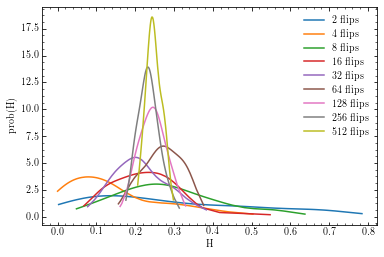

In [21]:
# actual value of H - here we expect to get tails 3 times out of 4

H = 0.25

# simulate the coin toss: true is heads, false is tails

N = 1024
flips = (np.random.rand(N) < H)

nflips = 1 << np.arange(1,10)

Hgrid = np.linspace(0,1,1000)
prior = lambda H: 1.

for n in nflips:
    nh = flips[:n].sum()
    
    def likelihood(H):
        if 0 < H and 1 > H:
            return np.log(prior(H)) + nh * np.log(H) + (n-nh) * np.log(1-H)
        else:
            return -np.inf
    
    ndim, nwalkers = 1, 100
    
    p0 = np.random.rand(nwalkers, 1) #[np.random.rand() for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood)
    # initial burn-in run
    sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    pos, prob, state = sampler.run_mcmc(p0, 1000)
    
    pos = pos.flatten()
    plt.plot(np.sort(pos), gaussian_kde(pos)(np.sort(pos)), label="%d flips"%n)
    #plt.hist(pos, np.linspace(0,1,101), normed=True, facecolor=None)
    
    #dist = prior * Hgrid**(flips[:n].sum()) * (1-Hgrid)**(n - flips[:n].sum())
    #dist /= dist.sum() / len(Hgrid)
    #plt.plot(Hgrid,dist, label="%d flips"%n)

plt.legend()
plt.xlabel("H")
plt.ylabel("prob(H)")
plt.show()

# Lighthouse Problem

We'll simulate the lighthouse by sampling the flash angles from a uniform distribution from 0 to Pi. Then the data are where those flashes land, alpha + beta tan(theta)

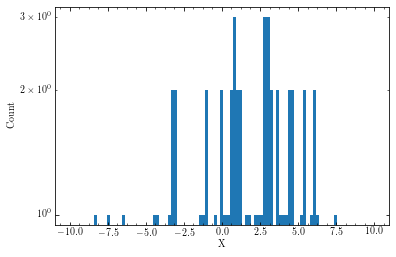

In [26]:
alpha = 2
beta = 2

N = 64
theta = np.random.rand(N)*np.pi

flashes = alpha + beta * np.tan(theta)

plt.hist(flashes,np.linspace(-10,10,100))
plt.yscale('log')
plt.xlabel("X")
plt.ylabel("Count")
plt.show()

Now we'll do MCMC sampling and just look at the scatter plot of the sampled points

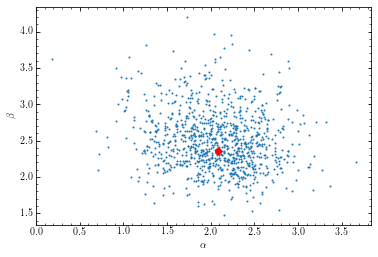

In [48]:
def Cauchy(x, alpha, beta):
    return 1/(1 + ((x - alpha)/beta)**2)/np.pi/beta

def lnprob(X, data):
    alpha, beta = X
    if beta < 0:
        return -np.inf
    else:
        return np.log(Cauchy(data, alpha, beta)).sum()

    
ndim, nwalkers = 2, 1000
    
p0 = np.random.rand(nwalkers, 2) #[np.random.rand() for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(flashes,), threads=6)
# initial burn-in run
sampler.run_mcmc(p0, 100)
sampler.reset()
    
pos, prob, state = sampler.run_mcmc(p0, 1000)

plt.scatter(pos[:,0], pos[:,1],s=1)
plt.scatter([pos[prob.argmax(),0],], [pos[prob.argmax(),1],], color='red')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.show()

We can add an interloper signal by contaminating the dataset with some flashes originating from a different position

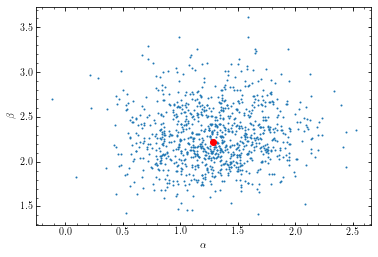

In [49]:
alpha1, beta1 = 0, 1

theta = np.random.rand(16)*np.pi

flashes2 = alpha1 + beta1 * np.tan(theta)

flashes2 = np.concatenate([flashes, flashes2])

ndim, nwalkers = 2, 1000
    
p0 = np.random.rand(nwalkers, 2) #[np.random.rand() for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(flashes2,), threads=6)
# initial burn-in run
sampler.run_mcmc(p0, 100)
sampler.reset()
    
pos, prob, state = sampler.run_mcmc(p0, 1000)

plt.scatter(pos[:,0], pos[:,1],s=1)
plt.scatter([pos[prob.argmax(),0],], [pos[prob.argmax(),1],], color='red')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.show()

It looks like the interloper shifts our point cloud over toward it somewhat